In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model

In [2]:
from fastai.vision.all import *

In [3]:
set_seed(365, reproducible=True)
BATCH_SIZE = 32

In [4]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

(#5) [Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/train')]

In [5]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,1,1,1,0,0,0,0,0,0,1,0,35,../input/petfinder-pawpularity-score/train/093a98eacf91b2ec104fc1da28c60dc3.jpg
1,0,0,0,1,0,0,0,0,1,0,0,0,31,../input/petfinder-pawpularity-score/train/3502775be0d0935b507ddf7864facd65.jpg
2,0,1,1,1,0,0,0,0,0,0,0,0,40,../input/petfinder-pawpularity-score/train/bf68040faf8f3f0b35755c795ca08fd1.jpg
3,0,1,1,1,0,0,0,0,0,0,0,0,28,../input/petfinder-pawpularity-score/train/a974610d3b42b6b901276210144d834e.jpg
4,0,0,0,1,0,0,0,0,1,1,0,0,30,../input/petfinder-pawpularity-score/train/173218368c3a01062359b4052ba64854.jpg


In [7]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


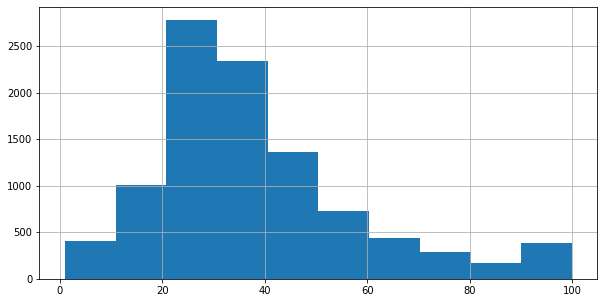

In [8]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [9]:
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")


There are 100 unique values of Pawpularity score


In [10]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.35
1       0.31
2       0.40
3       0.28
4       0.30
        ... 
9907    0.23
9908    0.27
9909    0.67
9910    0.48
9911    0.25
Name: norm_score, Length: 9912, dtype: float64

In [11]:
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

1024 768


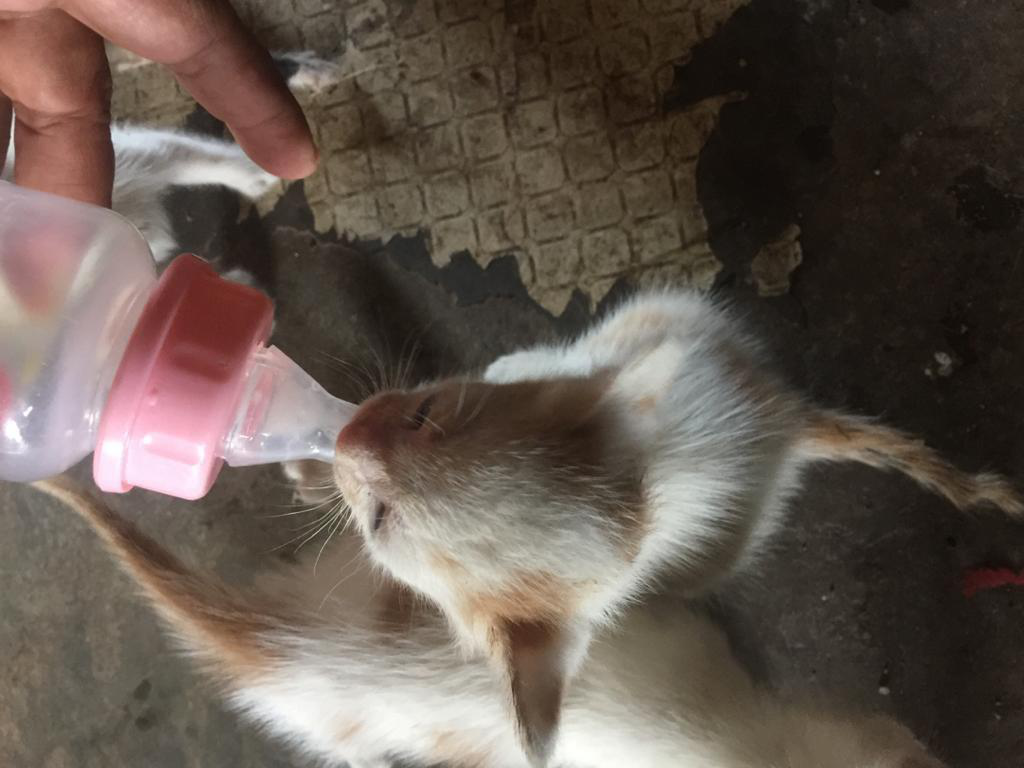

In [12]:
im

In [13]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [14]:
seed=365
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [15]:
import math
#Rice rule
num_bins = int(np.ceil(2*((len(train_df))**(1./3))))
num_bins

43

<AxesSubplot:>

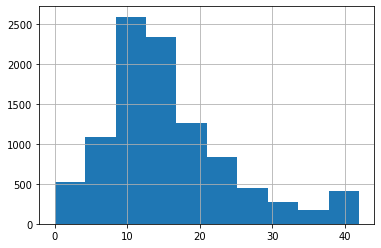

In [16]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

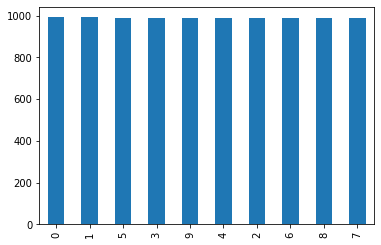

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [18]:
train_df[train_df['fold']==0].head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
6,0,1,1,1,0,0,0,0,0,0,0,0,34,../input/petfinder-pawpularity-score/train/87026c16e89f0d04011b90bfb827ad90.jpg,0.34,14,0
22,0,1,1,1,0,0,0,0,0,0,0,0,54,../input/petfinder-pawpularity-score/train/e7bb61a6630101aad7d24ca1e8741788.jpg,0.54,23,0
23,0,1,1,0,0,0,1,0,0,0,0,0,100,../input/petfinder-pawpularity-score/train/f26409c9f5fedae715b44cb7fd2168ed.jpg,1.00,42,0
24,0,0,1,1,0,0,0,0,0,0,0,1,19,../input/petfinder-pawpularity-score/train/5f1dfc3290b10cb22cf2fb16d79ef95d.jpg,0.19,7,0
34,0,1,1,1,0,0,0,0,0,0,0,0,20,../input/petfinder-pawpularity-score/train/d042a84e62e2ab515aefa6f2e45d4947.jpg,0.20,8,0


In [19]:
train_df[train_df['fold']==0]['bins'].value_counts()

13    84
9     75
12    62
11    62
10    60
16    55
14    50
15    46
19    37
17    36
8     36
42    31
7     30
6     28
18    28
20    23
23    22
21    19
0     17
22    16
26    16
5     14
24    13
25    13
4     12
3     11
27    10
29     9
28     8
30     8
33     8
1      7
31     6
32     6
2      6
36     5
37     4
35     4
39     4
34     4
40     3
38     2
41     2
Name: bins, dtype: int64

In [20]:
train_df[train_df['fold']==1]['bins'].value_counts()

13    84
9     74
12    62
11    62
10    60
16    55
14    50
15    46
19    37
17    36
8     36
7     31
42    30
18    28
6     27
20    24
23    22
21    19
0     17
22    17
26    16
5     14
24    13
25    13
4     12
3     11
29    10
27    10
28     8
30     8
33     8
1      7
32     6
2      6
31     6
36     5
37     4
34     4
39     4
40     3
35     3
41     2
38     2
Name: bins, dtype: int64

In [21]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [22]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=365, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls

In [23]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [24]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [25]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [26]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=4.828246164834127e-05)

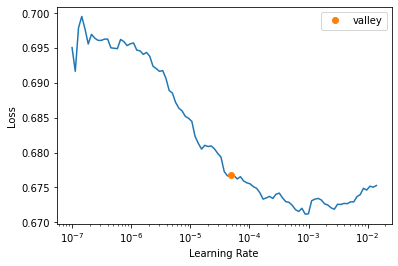

In [27]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [28]:
import gc

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.652678,0.644052,18.013990,04:41
1,0.642014,0.637619,17.131594,04:43
2,0.637502,0.636814,16.980558,04:42
3,0.629582,0.637642,17.110010,04:42
4,0.627149,0.638106,17.153519,04:42


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6440520286560059.
Better model found at epoch 1 with valid_loss value: 0.6376190185546875.
Better model found at epoch 2 with valid_loss value: 0.6368143558502197.
No improvement since epoch 2: early stopping


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650187,0.641737,17.560555,04:42
1,0.639838,0.638495,17.066515,04:42
2,0.635105,0.638376,17.064898,04:42
3,0.630380,0.637608,16.937693,04:42
4,0.623779,0.637741,16.927475,04:43


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6417374014854431.
Better model found at epoch 1 with valid_loss value: 0.6384953260421753.
Better model found at epoch 2 with valid_loss value: 0.6383761763572693.
Better model found at epoch 3 with valid_loss value: 0.6376075148582458.


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648118,0.646505,18.017908,04:42
1,0.643117,0.643849,17.694296,04:41
2,0.636527,0.645578,17.851015,04:42
3,0.629954,0.644852,17.753735,04:43


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6465054154396057.
Better model found at epoch 1 with valid_loss value: 0.6438487768173218.
No improvement since epoch 1: early stopping


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647772,0.646547,18.090603,04:43
1,0.641580,0.643867,17.748505,04:42
2,0.637700,0.645875,17.960884,04:41
3,0.626615,0.644069,17.757355,04:41


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6465469598770142.
Better model found at epoch 1 with valid_loss value: 0.6438673138618469.
No improvement since epoch 1: early stopping


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647739,0.643627,17.662954,04:43
1,0.639358,0.641776,17.399588,04:41
2,0.633372,0.640224,17.188456,04:41
3,0.628837,0.641369,17.307068,04:42
4,0.624089,0.641746,17.348627,04:40


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6436267495155334.
Better model found at epoch 1 with valid_loss value: 0.641776442527771.
Better model found at epoch 2 with valid_loss value: 0.6402242183685303.
No improvement since epoch 2: early stopping


Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650919,0.650217,18.685928,04:42
1,0.638431,0.645339,18.031017,04:41
2,0.636905,0.643408,17.787197,04:41
3,0.631890,0.643134,17.722994,04:41
4,0.626670,0.643210,17.743587,04:40


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6502169966697693.
Better model found at epoch 1 with valid_loss value: 0.6453385353088379.
Better model found at epoch 2 with valid_loss value: 0.6434075236320496.
Better model found at epoch 3 with valid_loss value: 0.6431341171264648.


Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649941,0.644903,17.916203,04:41
1,0.640738,0.640417,17.264393,04:41
2,0.633706,0.640696,17.236496,04:40
3,0.627197,0.641289,17.305353,04:40
4,0.625827,0.641658,17.340269,04:40


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6449025869369507.
Better model found at epoch 1 with valid_loss value: 0.6404168009757996.
No improvement since epoch 2: early stopping


Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648543,0.640708,17.494804,04:40
1,0.645478,0.639601,17.337936,04:39
2,0.635384,0.636918,16.929382,04:41
3,0.630725,0.635538,16.743053,04:41
4,0.628664,0.635420,16.714218,04:40


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6407083868980408.
Better model found at epoch 1 with valid_loss value: 0.6396011114120483.
Better model found at epoch 2 with valid_loss value: 0.6369179487228394.
Better model found at epoch 3 with valid_loss value: 0.6355383396148682.
Better model found at epoch 4 with valid_loss value: 0.6354197263717651.


Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649618,0.644509,17.999063,04:40
1,0.643392,0.640899,17.545156,04:40
2,0.634517,0.636889,16.968002,04:39
3,0.632145,0.637080,17.003311,04:41
4,0.624184,0.637211,17.024927,04:40


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6445093154907227.
Better model found at epoch 1 with valid_loss value: 0.6408989429473877.
Better model found at epoch 2 with valid_loss value: 0.6368892192840576.
No improvement since epoch 2: early stopping


Fold 9 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.651557,0.640553,17.563345,04:41
1,0.639361,0.636610,17.068020,04:41
2,0.640721,0.635607,16.946405,04:42
3,0.631544,0.636136,16.964539,04:41
4,0.629063,0.635626,16.921732,04:41


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6405532956123352.
Better model found at epoch 1 with valid_loss value: 0.6366099715232849.
Better model found at epoch 2 with valid_loss value: 0.6356068253517151.


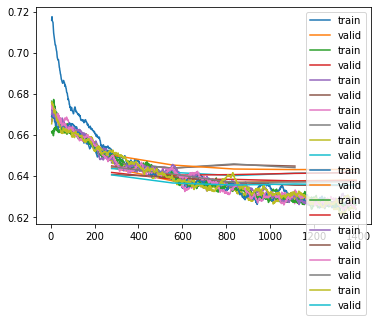

In [29]:
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=365, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [30]:
all_preds

[tensor([[0.4683],
         [0.4542],
         [0.4683],
         [0.4635],
         [0.4638],
         [0.4582],
         [0.4689],
         [0.4813]]),
 tensor([[0.5009],
         [0.4953],
         [0.4971],
         [0.4923],
         [0.4752],
         [0.4886],
         [0.4932],
         [0.5010]]),
 tensor([[0.4642],
         [0.4613],
         [0.4740],
         [0.4701],
         [0.4597],
         [0.4592],
         [0.4607],
         [0.4715]]),
 tensor([[0.4904],
         [0.4852],
         [0.4931],
         [0.4939],
         [0.4667],
         [0.4810],
         [0.4878],
         [0.4967]]),
 tensor([[0.5024],
         [0.4984],
         [0.5048],
         [0.4972],
         [0.4830],
         [0.4889],
         [0.5028],
         [0.5095]]),
 tensor([[0.5140],
         [0.5098],
         [0.5125],
         [0.5112],
         [0.5016],
         [0.5011],
         [0.5121],
         [0.5120]]),
 tensor([[0.5110],
         [0.5079],
         [0.5129],
         [0.5125],


In [31]:
np.mean(np.stack(all_preds*100))

0.4965883

In [32]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [33]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,49.965904
1,43a2262d7738e3d420d453815151079e,49.484150
2,4e429cead1848a298432a0acad014c9d,50.145160
3,80bc3ccafcc51b66303c2c263aa38486,49.827106
4,8f49844c382931444e68dffbe20228f4,48.653507
